In [152]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, f1_score
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

# Traffic dataset

In [2]:
df=pd.read_csv('/Users/maksimtrebusinin/Downloads/archive-2/TrafficTwoMonth.csv')
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal
...,...,...,...,...,...,...,...,...,...
5947,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
5948,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
5949,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
5950,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


In [3]:
df_num=df.select_dtypes('int')

<Axes: >

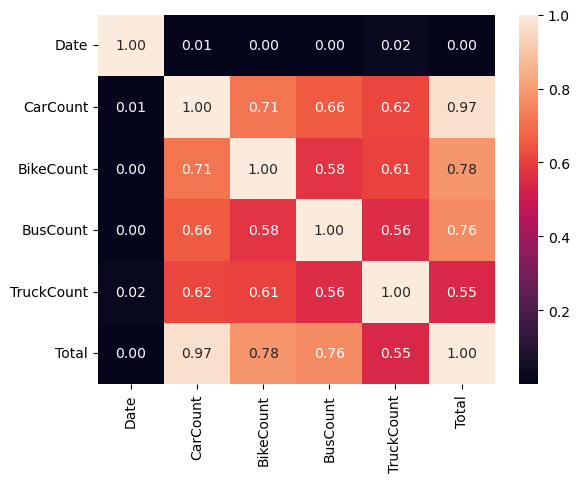

In [5]:
sns.heatmap(abs(df_num.corr()), annot=True, fmt='.2f', cbar=True)

In [6]:
df.isna().sum()

Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               5952 non-null   object
 1   Date               5952 non-null   int64 
 2   Day of the week    5952 non-null   object
 3   CarCount           5952 non-null   int64 
 4   BikeCount          5952 non-null   int64 
 5   BusCount           5952 non-null   int64 
 6   TruckCount         5952 non-null   int64 
 7   Total              5952 non-null   int64 
 8   Traffic Situation  5952 non-null   object
dtypes: int64(6), object(3)
memory usage: 418.6+ KB


In [8]:
df.describe()

,Date,CarCount,BikeCount,BusCount,TruckCount,Total
count,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000,5952.000000
mean,16.000000,65.440692,12.161458,12.912970,18.646337,109.161458
std,8.945023,44.749335,11.537944,12.497736,10.973139,55.996312
min,1.000000,5.000000,0.000000,0.000000,0.000000,21.000000
25%,8.000000,18.750000,3.000000,2.000000,10.000000,54.000000
50%,16.000000,62.000000,9.000000,10.000000,18.000000,104.000000
75%,24.000000,103.000000,19.000000,20.000000,27.000000,153.000000
max,31.000000,180.000000,70.000000,50.000000,60.000000,279.000000


<Axes: >

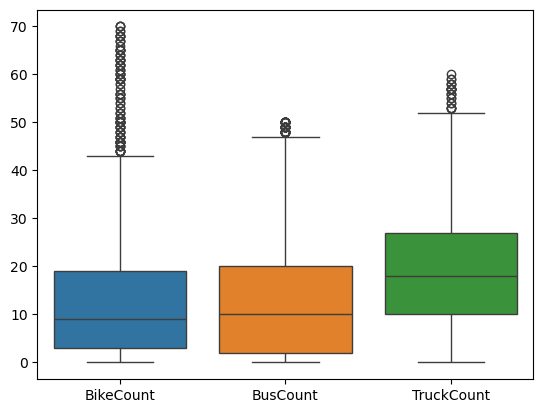

In [13]:
sns.boxplot(df_num[['BikeCount','BusCount','TruckCount']])

In [14]:
df[df['BikeCount']==max(df.BikeCount)]

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
3308,11:00:00 AM,13,Friday,169,70,20,3,262,heavy
3996,3:00:00 PM,20,Friday,140,70,23,4,237,heavy
5328,12:00:00 PM,3,Friday,148,70,15,0,233,heavy


In [18]:
df.duplicated().sum()

0

In [20]:
lab=LabelEncoder()
for col in df.columns:
    if df[col].dtypes=='object':
        df[col]=lab.fit_transform(df[col])

In [23]:
for col in df.columns:
    print(f'df[{col}] unique = {df[col].nunique()}')

df[Time] unique = 96
df[Date] unique = 31
df[Day of the week] unique = 7
df[CarCount] unique = 173
df[BikeCount] unique = 71
df[BusCount] unique = 51
df[TruckCount] unique = 59
df[Total] unique = 239
df[Traffic Situation] unique = 4


In [30]:
df['Traffic Situation'].value_counts()

3    3610
0    1137
2     834
1     371
Name: Traffic Situation, dtype: int64

In [31]:
X,y=df.drop('Traffic Situation', axis=1), df['Traffic Situation']
smote=SMOTE(sampling_strategy='auto', k_neighbors=5, n_jobs=-1)
X_res, y_res=smote.fit_resample(X,y)

/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res, test_size=0.25, stratify=y_res, random_state=42)
print(f'Count of classes in train_data: ({np.bincount(y_train)})')
print(f'Count of classes in test_data: ({np.bincount(y_test)})')

Count of classes in train_data: ([2707 2708 2707 2708])
Count of classes in test_data: ([903 902 903 902])


In [39]:
clf_rnf=RandomForestClassifier()
clf_rnf.fit(X_train,y_train)

RandomForestClassifier()

Accuracy is: 0.9975069252077562


<Axes: >

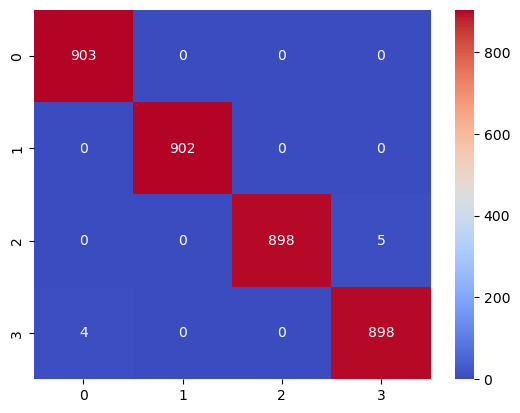

In [41]:
pred_rnf=clf_rnf.predict(X_test)
print(f'Accuracy is: {accuracy_score(y_test,pred_rnf)}')
sns.heatmap(confusion_matrix(y_test,pred_rnf), annot=True, fmt='d', cmap='coolwarm')

In [44]:
X_res['Target']=y_res
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_res.drop(['CarCount','Total'], axis=1), 
                                                                    X_res.CarCount, test_size=0.25, random_state=42)

In [47]:
bag_reg=BaggingRegressor()
bag_reg.fit(X_train_reg,y_train_reg)

BaggingRegressor()

In [49]:
pred_reg=bag_reg.predict(X_test_reg)
print(f'MAE is: {mean_absolute_error(y_test_reg, pred_reg)}')

MAE is: 6.42670412874291


In [55]:
def objective(trial):
    params={
        'n_estimators':trial.suggest_int('n_estimators', 10, 100),
        'max_samples':trial.suggest_int('max_samples', 1,10),
        'max_features':trial.suggest_int('max_features', 1,3)
    }

    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    model=BaggingRegressor(**params, n_jobs=-1)
    cross_val=cross_val_score(model,X_res.drop(['CarCount','Total'], axis=1),X_res.CarCount, cv=cv, scoring='neg_mean_absolute_error')
    return np.mean(cross_val)

    

In [57]:
study=optuna.create_study(study_name='bag_regressor')
study.optimize(objective, n_trials=25)

[I 2024-09-29 20:51:47,865] A new study created in memory with name: bag_regressor
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
[I 2024-09-29 20:51:48,137] Trial 0 finished with value: -21.03208495970788 and parameters: {'n_estimators': 88, 'max_samples': 8, 'max_features': 3}. Best is trial 0 with value: -21.03208495970788.
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
[I 2024-09-29 20:51:48,377] Trial 1 finished with value: -31.542036011080334 and parameters: {'n_estimators': 86, 'max_samples': 2, 'max_features': 3}. Best is trial 1 with value: -31.542036011080334.
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in 

# MBA dataset

In [121]:
df_mba=pd.read_csv('/Users/maksimtrebusinin/Downloads/MBA.csv')
df_mba

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN
...,...,...,...,...,...,...,...,...,...,...
6189,6190,Male,False,3.49,Business,White,640.0,5.0,Other,NaN
6190,6191,Male,False,3.18,STEM,Black,670.0,4.0,Consulting,NaN
6191,6192,Female,True,3.22,Business,NaN,680.0,5.0,Health Care,Admit
6192,6193,Male,True,3.36,Business,NaN,590.0,5.0,Other,NaN


In [122]:
df_mba.isna().sum()

application_id       0
gender               0
international        0
gpa                  0
major                0
race              1842
gmat                 0
work_exp             0
work_industry        0
admission         5194
dtype: int64

In [123]:
df_mba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   application_id  6194 non-null   int64  
 1   gender          6194 non-null   object 
 2   international   6194 non-null   bool   
 3   gpa             6194 non-null   float64
 4   major           6194 non-null   object 
 5   race            4352 non-null   object 
 6   gmat            6194 non-null   float64
 7   work_exp        6194 non-null   float64
 8   work_industry   6194 non-null   object 
 9   admission       1000 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 441.7+ KB


In [124]:
for col in df_mba.columns:
    print(f'df_mba[{col}] unique values: {df_mba[col].nunique()}')

df_mba[application_id] unique values: 6194
df_mba[gender] unique values: 2
df_mba[international] unique values: 2
df_mba[gpa] unique values: 101
df_mba[major] unique values: 3
df_mba[race] unique values: 5
df_mba[gmat] unique values: 22
df_mba[work_exp] unique values: 9
df_mba[work_industry] unique values: 14
df_mba[admission] unique values: 2


In [125]:
df_mba.drop('application_id', axis=1, inplace=True)

In [126]:
df_mba.duplicated().sum()

30

In [127]:
df_mba.drop_duplicates(inplace=True)

In [128]:
df_mba.duplicated().sum()

0

<Axes: >

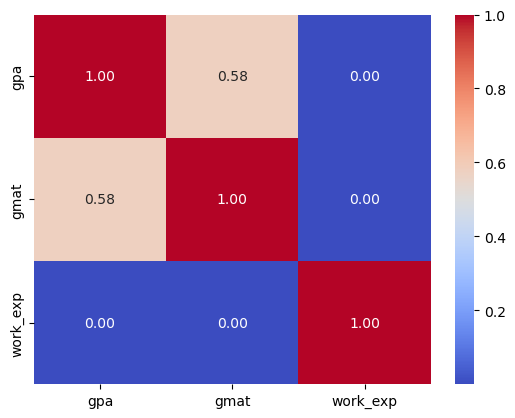

In [129]:
df_mba_num=df_mba.select_dtypes(['int','float'])
sns.heatmap(abs(df_mba_num.corr()), annot=True, fmt='.2f', cmap='coolwarm')

In [130]:
df_mba.race.value_counts()

White       1452
Asian       1143
Black        909
Hispanic     596
Other        236
Name: race, dtype: int64

In [131]:
df_mba[df_mba['admission'].isna()==False].admission.value_counts()

Admit       899
Waitlist    100
Name: admission, dtype: int64

In [132]:
df_mba.race.fillna('White', inplace=True)
df_mba.isna().sum()

gender              0
international       0
gpa                 0
major               0
race                0
gmat                0
work_exp            0
work_industry       0
admission        5165
dtype: int64

<Axes: >

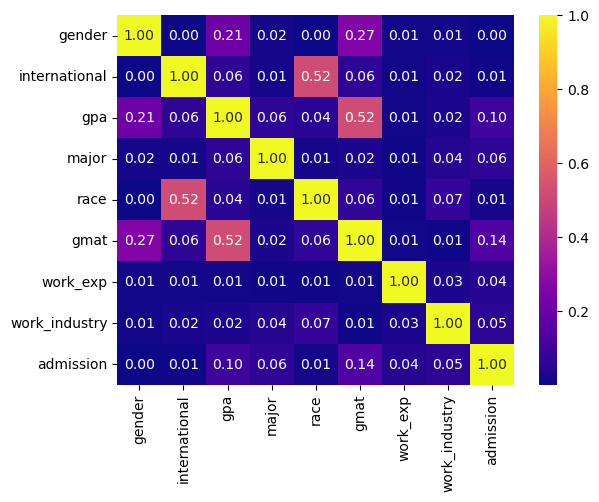

In [133]:
mask=df_mba.notnull().all(axis=1)
df_race_and_admission=df_mba[mask]
for col in df_race_and_admission.columns:
    if df_race_and_admission[col].dtype=='object' or df_race_and_admission[col].dtype=='bool':
        df_race_and_admission[col]=LabelEncoder().fit_transform(df_race_and_admission[col])
sns.heatmap(abs(df_race_and_admission.corr()), annot=True, fmt='.2f', cmap='plasma')

In [135]:
original=df_mba.copy()
mask_isnull=df_mba.isnull()
le=LabelEncoder()
for col in df_mba.columns:
    if df_mba[col].dtype=='object' or df_mba[col].dtype=='bool':
        df_mba[col]=le.fit_transform(df_mba[col])
df_mba=df_mba.where(~mask_isnull, original)

In [136]:
df_mba.isna().sum()

gender              0
international       0
gpa                 0
major               0
race                0
gmat                0
work_exp            0
work_industry       0
admission        5165
dtype: int64

In [137]:
df_mba

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,0,0,3.30,0,0,620.0,3.0,3,0
1,1,0,3.28,1,1,680.0,5.0,6,NaN
2,0,1,3.30,0,4,710.0,5.0,13,0
3,1,0,3.47,2,1,690.0,6.0,13,NaN
4,1,0,3.35,2,2,590.0,5.0,1,NaN
...,...,...,...,...,...,...,...,...,...
6189,1,0,3.49,0,4,640.0,5.0,9,NaN
6190,1,0,3.18,2,1,670.0,4.0,1,NaN
6191,0,1,3.22,0,4,680.0,5.0,4,0
6192,1,1,3.36,0,4,590.0,5.0,9,NaN


In [138]:
df_mba_for_reproduction=df_mba[df_mba['admission'].isna()==False]
print(df_mba_for_reproduction.admission.value_counts())

0    899
1    100
Name: admission, dtype: int64


In [141]:
imputer=KNNImputer(n_neighbors=5, weights='uniform')
imp=imputer.fit_transform(df_mba)
df_mba_final=pd.DataFrame(data=imp, columns=df_mba.columns)

In [143]:
df_mba_final['admission']=df_mba_final['admission'].astype('int')
df_mba_final['gender']=df_mba_final['gender'].astype('int')
df_mba_final['international']=df_mba_final['international'].astype('int')
df_mba_final['work_industry']=df_mba_final['work_industry'].astype('int')
df_mba_final['race']=df_mba_final['race'].astype('int')
df_mba_final['major']=df_mba_final['major'].astype('int')

In [145]:
df_mba_final.admission.value_counts()

0    6022
1     142
Name: admission, dtype: int64

In [146]:
X,y=df_mba_final.drop('admission',axis=1), df_mba_final.admission
smote=SMOTE(sampling_strategy='auto', k_neighbors=5, n_jobs=-1)
X_res_mba,y_res_mba=smote.fit_resample(X,y)

In [148]:
X_train,X_test, y_train, y_test = train_test_split(X_res_mba,y_res_mba, test_size=0.25, stratify=y_res_mba, random_state=42)
print(f'Train выборка: {np.bincount(y_train)}')
print(f'Test выборка: {np.bincount(y_test)}')

Train выборка: [4516 4517]
Test выборка: [1506 1505]


In [149]:
def objective(trial):
    params={
        'n_estimators':trial.suggest_int('n_estimators', 100,1000),
        'max_depth':trial.suggest_int('max_depth', 10, 200),
        'learning_rate':trial.suggest_float('learning_rate', 0.005, 0.01),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5)
    }
    XGB={
        'tree_method':'hist'
    }
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    model=XGBClassifier(**params, **XGB, n_jobs=-1)
    cross_val=cross_val_score(model, X_res_mba,y_res_mba, cv=cv, scoring='accuracy')
    return np.mean(cross_val)

In [150]:
study=optuna.create_study(study_name='xgb_classifier', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-10-02 18:01:18,441] A new study created in memory with name: xgb_classifier
[I 2024-10-02 18:01:25,311] Trial 0 finished with value: 0.9717699645717595 and parameters: {'n_estimators': 611, 'max_depth': 42, 'learning_rate': 0.006659979768577241, 'min_child_weight': 4}. Best is trial 0 with value: 0.9717699645717595.
[I 2024-10-02 18:01:32,833] Trial 1 finished with value: 0.9720189961538992 and parameters: {'n_estimators': 639, 'max_depth': 45, 'learning_rate': 0.006355151047640791, 'min_child_weight': 3}. Best is trial 1 with value: 0.9720189961538992.
[I 2024-10-02 18:01:39,185] Trial 2 finished with value: 0.9710228698253403 and parameters: {'n_estimators': 536, 'max_depth': 33, 'learning_rate': 0.006919208137435833, 'min_child_weight': 3}. Best is trial 1 with value: 0.9720189961538992.
[I 2024-10-02 18:01:47,628] Trial 3 finished with value: 0.9778308818461283 and parameters: {'n_estimators': 858, 'max_depth': 161, 'learning_rate': 0.00976494242147892, 'min_child_weight': 

In [151]:
xgb=XGBClassifier(**study.best_params)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.009704417613607933,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=41, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=960, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

f1_score is: 0.9808327825512226


<Axes: >

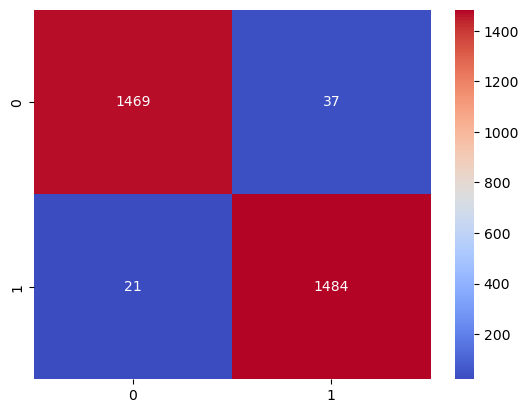

In [153]:
y_pred=xgb.predict(X_test)
print(f'f1_score is: {f1_score(y_test,y_pred)}')
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d', cmap='coolwarm')

In [154]:
def objective2(trial):
    params={
        'n_estimators':trial.suggest_int('n_estimators', 100,1000),
        'max_depth':trial.suggest_int('max_depth', 10, 200),
        'learning_rate':trial.suggest_float('learning_rate', 0.005, 0.01),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5)
    }
    XGB={
        'tree_method':'hist'
    }
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    model=XGBClassifier(**params, **XGB, n_jobs=-1)
    cross_val=cross_val_score(model, X_train,y_train, cv=cv, scoring='accuracy')
    return np.mean(cross_val)

In [155]:
study2=optuna.create_study(study_name='xgb_model2', direction='maximize')
study2.optimize(objective2, n_trials=50)

[I 2024-10-02 18:28:52,712] A new study created in memory with name: xgb_model2
[I 2024-10-02 18:28:58,984] Trial 0 finished with value: 0.9702205774262783 and parameters: {'n_estimators': 653, 'max_depth': 152, 'learning_rate': 0.007781030418599616, 'min_child_weight': 4}. Best is trial 0 with value: 0.9702205774262783.
[I 2024-10-02 18:29:09,114] Trial 1 finished with value: 0.9738740824586676 and parameters: {'n_estimators': 832, 'max_depth': 77, 'learning_rate': 0.00758753349287981, 'min_child_weight': 1}. Best is trial 1 with value: 0.9738740824586676.
[I 2024-10-02 18:29:14,013] Trial 2 finished with value: 0.9647963033742002 and parameters: {'n_estimators': 662, 'max_depth': 14, 'learning_rate': 0.006929957340853527, 'min_child_weight': 5}. Best is trial 1 with value: 0.9738740824586676.
[I 2024-10-02 18:29:25,903] Trial 3 finished with value: 0.9744276698125226 and parameters: {'n_estimators': 954, 'max_depth': 145, 'learning_rate': 0.007010941389346754, 'min_child_weight': 1}.

In [157]:
xgb2=XGBClassifier(**study2.best_params)
xgb2.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.009348262607511955,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=178, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=932, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

f1_score is: 0.9808327825512226


<Axes: >

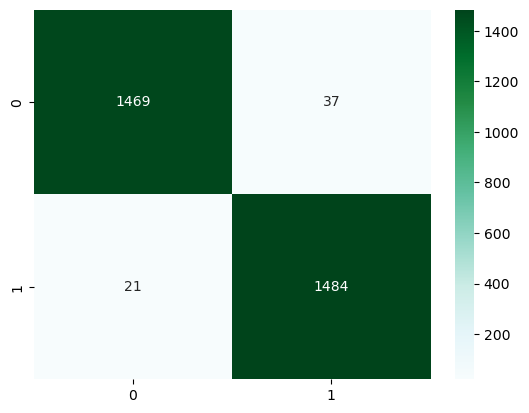

In [158]:
y_pred2=xgb2.predict(X_test)
print(f'f1_score is: {f1_score(y_test,y_pred2)}')
sns.heatmap(confusion_matrix(y_test,y_pred2), annot=True, fmt='d', cmap='BuGn')